Using Colab cache for faster access to the 'mimic-iv-clinical-database-demo-2-2' dataset.

Top 10 Diseases (with Names):
  icd_code  count                                         long_title
0     4019     68                 Unspecified essential hypertension
1     E785     57                        Hyperlipidemia, unspecified
2     2724     55               Other and unspecified hyperlipidemia
3     E039     47                        Hypothyroidism, unspecified
4     Z794     37                 Long term (current) use of insulin
5   Z87891     35            Personal history of nicotine dependence
6    42731     34                                Atrial fibrillation
7    I2510     33  Atherosclerotic heart disease of native corona...
8    25000     33  Diabetes mellitus without mention of complicat...
9      I10     32                   Essential (primary) hypertension


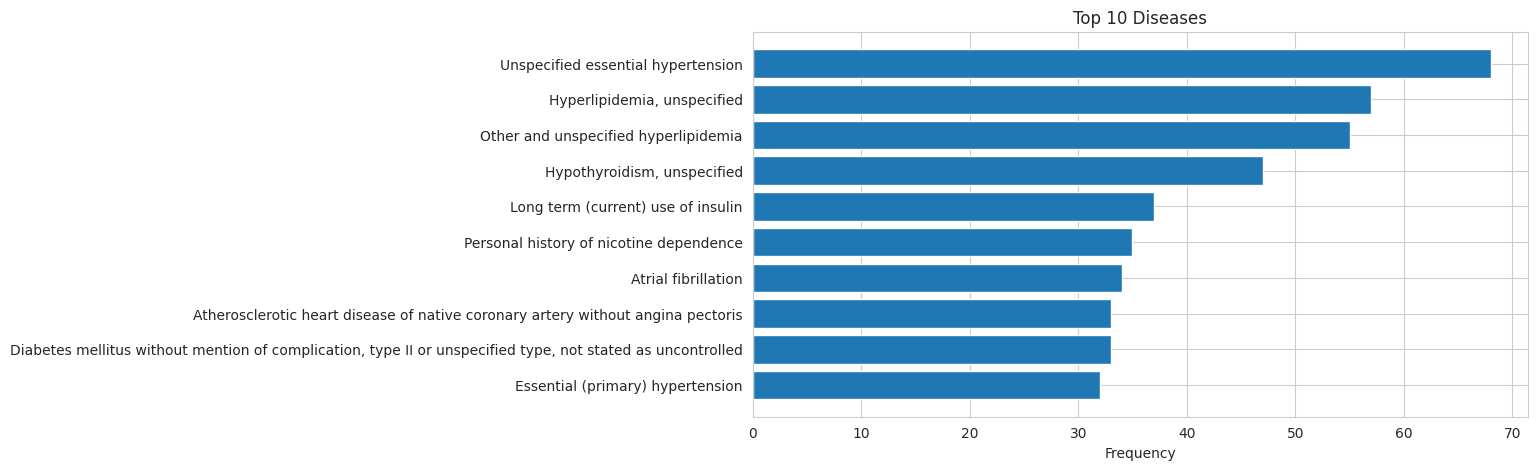


Top 10 Drugs:
medication
Insulin                        956
Sodium Chloride 0.9%  Flush    587
Furosemide                     510
Potassium Chloride             437
Heparin                        390
Metoprolol Tartrate            371
HYDROmorphone (Dilaudid)       345
Acetaminophen                  344
Vancomycin                     270
Docusate Sodium                250
Name: count, dtype: int64


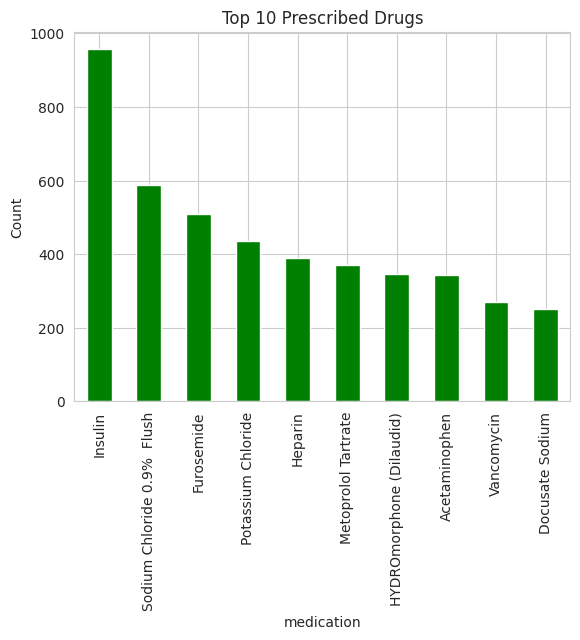


Top Disease–Drug Relationships:
                                              long_title medication  count
3834                   Acute kidney failure, unspecified    Insulin    442
9581                                 Anemia, unspecified    Insulin    339
35173                        Hyperlipidemia, unspecified    Insulin    332
11921  Atherosclerotic heart disease of native corona...    Insulin    315
38026                        Hypothyroidism, unspecified    Insulin    312
51627               Other and unspecified hyperlipidemia    Insulin    299
42175                 Long term (current) use of insulin    Insulin    292
68704  Presence of coronary angioplasty implant and g...    Insulin    275
42906                 Long-term (current) use of insulin    Insulin    235
49062                               Obesity, unspecified    Insulin    235

Top Drug–Drug Interaction Pairs:
                   medication_x                 medication_y  count
26203                   Insulin  Sodium 

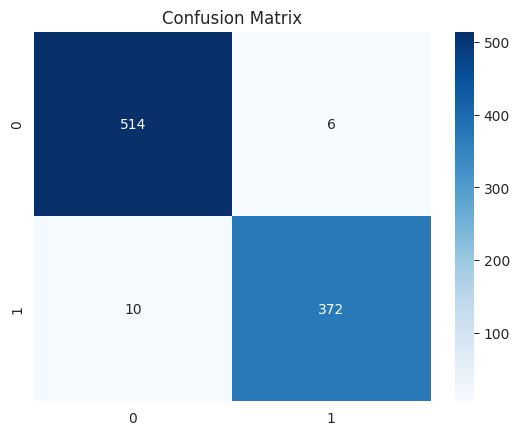

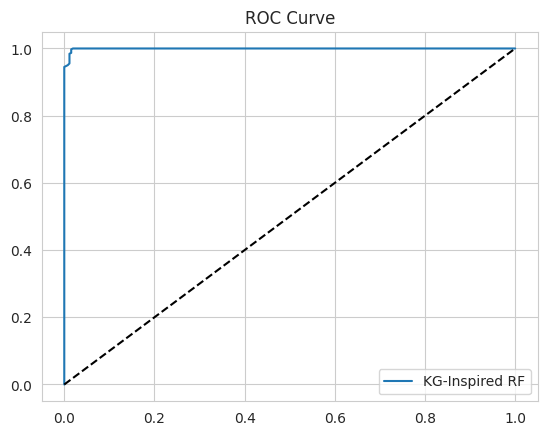

In [4]:
!pip install -q kagglehub

import kagglehub, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve
)

sns.set_style("whitegrid")

# STEP 1: DOWNLOAD DATASET
root = kagglehub.dataset_download(
    "montassarba/mimic-iv-clinical-database-demo-2-2"
)

hosp = os.path.join(root, "mimic-iv-clinical-database-demo-2.2", "hosp")

def load_csv(name):
    for f in os.listdir(hosp):
        if f.startswith(name):
            return pd.read_csv(os.path.join(hosp, f))
    raise FileNotFoundError(name)

patients   = load_csv("patients")
admissions = load_csv("admissions")
diagnoses  = load_csv("diagnoses_icd")
pharmacy   = load_csv("pharmacy")
icd_dict   = load_csv("d_icd_diagnoses")

# STEP 2: BASIC MERGE
df = admissions.merge(patients, on="subject_id")
df = df.merge(diagnoses, on=["subject_id","hadm_id"], how="left")

df["gender"] = df["gender"].map({"M":0,"F":1})
df = df.dropna(subset=["gender","anchor_age"])

# STEP 3: TOP DISEASES (WITH NAMES)
top_diseases = (
    diagnoses["icd_code"]
    .value_counts()
    .head(10)
    .reset_index()
)

top_diseases.columns = ["icd_code","count"]

top_diseases = top_diseases.merge(
    icd_dict[["icd_code","long_title"]],
    on="icd_code",
    how="left"
)

print("\nTop 10 Diseases (with Names):")
print(top_diseases)

plt.figure(figsize=(10,5))
plt.barh(top_diseases["long_title"], top_diseases["count"])
plt.xlabel("Frequency")
plt.title("Top 10 Diseases")
plt.gca().invert_yaxis()
plt.show()

# STEP 4: TOP DRUGS
top_drugs = pharmacy["medication"].value_counts().head(10)

print("\nTop 10 Drugs:")
print(top_drugs)

top_drugs.plot(kind="bar", color="green", title="Top 10 Prescribed Drugs")
plt.ylabel("Count")
plt.show()


# STEP 5: DISEASE → DRUG RELATION (KG CORE)
diag_drug = pharmacy.merge(
    diagnoses[["hadm_id","icd_code"]],
    on="hadm_id"
).merge(
    icd_dict[["icd_code","long_title"]],
    on="icd_code",
    how="left"
)

top_diag_drug = (
    diag_drug.groupby(["long_title","medication"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(10)
)

print("\nTop Disease–Drug Relationships:")
print(top_diag_drug)


# STEP 6: DRUG–DRUG INTERACTION (CLEAR & REALISTIC)
pairs = pharmacy.merge(pharmacy, on="hadm_id")
pairs = pairs[pairs["medication_x"] < pairs["medication_y"]]

ddi_pairs = (
    pairs.groupby(["medication_x","medication_y"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(10)
)

print("\nTop Drug–Drug Interaction Pairs:")
print(ddi_pairs)


# STEP 7: TARGET LABEL (ASPIRIN)
aspirin_hadm = pharmacy[
    pharmacy["medication"].str.contains("ASPIRIN", case=False, na=False)
]["hadm_id"].unique()

df["label"] = df["hadm_id"].isin(aspirin_hadm).astype(int)


# STEP 8: KG-INSPIRED FEATURES (DIAGNOSES)
top_icds = diagnoses["icd_code"].value_counts().head(30).index.tolist()
diag_red = diagnoses[diagnoses["icd_code"].isin(top_icds)]

diag_ohe = pd.get_dummies(diag_red["icd_code"])
diag_ohe["hadm_id"] = diag_red["hadm_id"]

diag_feat = diag_ohe.groupby("hadm_id").sum().reset_index()

df = df.merge(diag_feat, on="hadm_id", how="left")
df.fillna(0, inplace=True)


# STEP 9: TRAIN KG-INSPIRED MODEL
features = ["gender","anchor_age"] + top_icds
X = df[features]
y = df["label"]

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train,y_train)
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]


# STEP 10: FINAL RESULTS
print("\n=== KG-INSPIRED MODEL PERFORMANCE ===")
print("Accuracy :", accuracy_score(y_test,pred))
print("Precision:", precision_score(y_test,pred))
print("Recall   :", recall_score(y_test,pred))
print("F1-score :", f1_score(y_test,pred))

sns.heatmap(confusion_matrix(y_test,pred),
            annot=True,fmt="d",cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

fpr,tpr,_ = roc_curve(y_test,prob)
plt.plot(fpr,tpr,label="KG-Inspired RF")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curve")
plt.show()


